In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from scipy.stats import norm
import math
from scipy.special import eval_hermite as hermite
import pandas as pd

## simulation

In [2]:
def expo_quad_kernel(theta0,theta1,xn,xm):
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

In [3]:
T=100

In [4]:
xi=np.linspace(0+100/80/2,100-100/80/2,80)

In [5]:
x=np.linspace(0,100,1000)

In [6]:
f=np.zeros(1000)

In [7]:
alpha=norm.rvs(0,1,len(xi))

In [8]:
for i in range(len(f)):
    for j in range(len(xi)):
        f[i]+=alpha[j]*expo_quad_kernel(1,0.01,x[i],xi[j])

In [9]:
intensity=0.1*f**2 ## a_=0.1

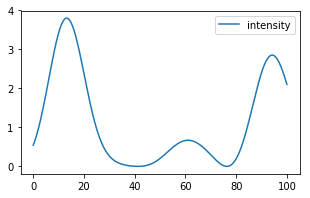

In [17]:
plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
axs.plot(x,intensity,label='intensity')
# plt.tick_params(labelsize=10)
plt.legend()
plt.show()

In [68]:
def inhomo_simulation(measure,delta_t,measure_sup,T):
    t=0
    points_homo=[]
    points_inhomo=[]
    while(t<T):
        points_homo.append(t)
        r=expon.rvs(scale=1/measure_sup) #scale=1/lamda
        t+=r
        if t>=T: break
        D=uniform.rvs(loc=0,scale=1)
        if D*measure_sup<=measure[int(t/delta_t)]:
            points_inhomo.append(t)
    if points_inhomo[-1]>T:
        del points_inhomo[-1]
    del points_homo[0]
    return points_inhomo

In [74]:
points_inhomo=inhomo_simulation(intensity,0.1,max(intensity),T)

In [75]:
len(points_inhomo)

303

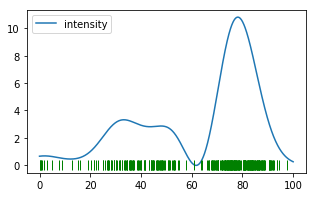

In [76]:
plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
axs.plot(x,intensity,label='intensity')
axs.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10)
plt.legend()
plt.show()

In [296]:
rawdata = pd.read_excel("./NYPD_Motor_Vehicle_Collisions.xlsx")

In [297]:
df=rawdata.loc[:,['DATE','TIME']]

In [298]:
df['DATE']=pd.to_datetime(df['DATE'])

In [299]:
training=[]

In [306]:
start=np.datetime64('2017-10-09')       # June, July, August
end=np.datetime64('2017-10-13')
interval = pd.date_range(start, end)

In [307]:
for i in interval:
    df_1=df[df['DATE']==i]

    df_1['ts']=df_1.apply(lambda r : pd.datetime.combine(r['DATE'],r['TIME']),1)

    df_1['ts']=df_1['ts'].astype(np.int64)

    df_1=df_1.sort_values(['ts'])

    training_data=df_1['ts'].values/1000000000  # convert to second

    training_data=training_data-training_data[0]+1

    training_data=training_data/60      # convert to minite, T=1440
    training_data=training_data/10      # convert to 10 minite, T=144
    
    for i in range(20):                 # delete points at 0
        if training_data[0]==training_data[1]:
            training_data=np.delete(training_data,1)
            
    for i in range(1,len(training_data)):  # divide points at same time
        for j in range(i):
            if training_data[j]==training_data[i]:
                training_data[i]+=0.01

    training.append(list(training_data))

C:\Users\zho045\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\zho045\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [325]:
del training[16][:10]

In [326]:
T=144

## inference

In [327]:
def k_sim(x_n,x_m,J,theta1,a_,gamma): # J is the truncated order of k_sim
    k_s=0
    sigma2=1/theta1
    a=1/4/sigma2
    b=1/2/sigma2   ## 1/2/l**2
    c=np.sqrt(a**2+2*a*b)
    A=a+b+c
    B=b/A
    eigenvalue=[]
    eigenvalue_ori=[]
    for j in range(J):
        e_j_n=1/np.sqrt(np.sqrt(a/c)*2**j*math.factorial(j))*np.exp(-(c-a)*x_n**2)*hermite(j,np.sqrt(2*c)*x_n)
        e_j_m=1/np.sqrt(np.sqrt(a/c)*2**j*math.factorial(j))*np.exp(-(c-a)*x_m**2)*hermite(j,np.sqrt(2*c)*x_m)
        eta=np.sqrt(2*a/A)*B**j
#         eigenvalue_ori.append(eta)
        eta_sim=eta/(a_*eta+gamma)
#         eigenvalue.append(eta_sim)
        k_s+=eta_sim*e_j_n*e_j_m
#     return k_s,eigenvalue,eigenvalue_ori
    return k_s

In [328]:
def loss(alp,K_sim,a_,points_inhomo):
    assert len(K_sim)==len(alp)==len(points_inhomo)
    N=len(alp)
    loss=0
    for i in range(N):
        loss-=np.log(((K_sim[i].dot(alp))**2)*a_)
    loss+=alp.dot(K_sim.dot(alp))
    return loss

In [329]:
def gradient(alp,K_sim,a_,points_inhomo):
    assert len(K_sim)==len(alp)
    N=len(alp)
    gradient=np.zeros(N)
    for i in range(N):
        gradient-=2*K_sim[i]/(K_sim[i].dot(alp))
    gradient+=2*K_sim.dot(alp)
    return gradient

In [330]:
def expo_quad_kernel(theta0,theta1,xn,xm):
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

In [331]:
def GP_regression(xi,yi,theta0,theta1,noise_var,rang,num_points):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov_K[j][i]=cov_K[i][j]
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K))) # numerical float truncation error refine
    while(min_eig<0):
        cov_K += -10*min_eig*np.eye(cov_K.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K)))
    
    cov_K_noise=cov_K+np.eye(N)*noise_var
    
    x1=np.linspace(0,rang,num_points+1)      # prediction points, integer is to make it easy
    M=len(x1)-1
    mean=np.zeros((1,M))[0]
    posterior_cov=np.zeros((M,M))
    k_matrix=np.zeros((M,N))
    k_matrix_pre=np.zeros((M,M))
    for i in range(M):
        for j in range(N):
            k_matrix[i][j]=expo_quad_kernel(theta0,theta1,x1[i],xi[j])
    k_C=np.dot(k_matrix,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    for i in range(M):
        for j in range(i,M):
            k_matrix_pre[i][j]=expo_quad_kernel(theta0,theta1,x1[i],x1[j])
            k_matrix_pre[j][i]=k_matrix_pre[i][j]
    posterior_cov=k_matrix_pre-np.dot(k_C,k_matrix.T)+np.eye(M)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov))) # numerical float truncation error refine
    while(min_eig<0):
        posterior_cov += -10*min_eig*np.eye(posterior_cov.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov)))
    return x1[:num_points],mean, posterior_cov

In [332]:
theta0=1
theta1=0.01

In [333]:
a_=0.012
theta1=0.005
gamma=0.3

In [355]:
intensity_list=[]
for s in range(12):
    N=len(training[s])
    K_sim=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            K_sim[i][j]=k_sim(training[s][i],training[s][j],40,theta1,a_,gamma)
            K_sim[j][i]=K_sim[i][j]
    init=norm.rvs(0,1,N)
    res=optimize.minimize(loss, init, args=(K_sim,a_,training[s]), method='SLSQP', jac=gradient, bounds=[(-100,100)]*N, options={'disp': True})
    intensity_pre=np.zeros(N)
    for i in range(N):
        intensity_pre[i]=a_*(K_sim[i].dot(res.x))**2
    xx,intensity_pre_uniform,_=GP_regression(training[s],intensity_pre,theta0,theta1,0.0001,T,100)
    intensity_list.append(intensity_pre_uniform)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -232.67921236677773
            Iterations: 44
            Function evaluations: 73
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -602.9360034304209
            Iterations: 47
            Function evaluations: 73
            Gradient evaluations: 47
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -490.21909243170967
            Iterations: 39
            Function evaluations: 61
            Gradient evaluations: 39
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 271.4784020180739
            Iterations: 41
            Function evaluations: 70
            Gradient evaluations: 41
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 147.23581981251914
            Iterations: 55
            Functi

In [356]:
intensity_ave=np.average(intensity_list,axis=0)
intensity_ave=np.array([0.0001 if i < 0 else i for i in intensity_ave])

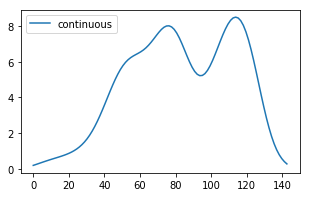

In [357]:
plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
# axs.plot(x,intensity,label='intensity')
# axs.plot(training[0],np.zeros(len(training[0])),linestyle='None', marker='|', color='g', markersize=10)
# axs.scatter(training[0],intensity_pre,label='dots',s=3)
axs.plot(xx,intensity_ave,label='continuous')
plt.legend()
plt.show()

In [358]:
sum(intensity_ave*1.44)

652.5439143133738

In [359]:
def loglikelihood(lamda,points_poisson,T):  ## discrete lamda
    N=len(lamda)
    M=len(points_poisson)
    delta_t=T/N
    logL=0
    for i in range(M):
        logL+=np.log(lamda[int(points_poisson[i]/delta_t)])
    logL-=sum(lamda*delta_t)
    return logL

## 1 training sequence

In [339]:
logL_test=[]
for i in range(12,17):
    logL_test.append(loglikelihood(np.array(intensity_ave),training[i],T))

In [340]:
np.average(logL_test)

277.5363628126262

## 5 training sequence

In [346]:
logL_test=[]
for i in range(12,17):
    logL_test.append(loglikelihood(np.array(intensity_ave),training[i],T))

In [347]:
np.average(logL_test)

356.76497972487675

## 9 training sequence

In [353]:
logL_test=[]
for i in range(12,17):
    logL_test.append(loglikelihood(np.array(intensity_ave),training[i],T))

In [354]:
np.average(logL_test)

366.1949270012843

## 12 training sequence

In [360]:
logL_test=[]
for i in range(12,17):
    logL_test.append(loglikelihood(np.array(intensity_ave),training[i],T))

In [361]:
np.average(logL_test)

349.4695698280506

In [386]:
rawdata = pd.read_csv("./2016_Green_Taxi_Trip_Data.csv")

In [387]:
date_series=['01/02/2016','01/03/2016','01/04/2016','01/05/2016','01/06/2016','01/07/2016','01/08/2016','01/09/2016',
            '01/10/2016','01/11/2016','01/12/2016','01/13/2016','01/14/2016','01/15/2016','01/16/2016',
            '01/17/2016','01/18/2016','01/19/2016','01/20/2016','01/21/2016','01/22/2016','01/23/2016',
            '01/24/2016','01/25/2016','01/26/2016','01/27/2016','01/28/2016','01/29/2016','01/30/2016','01/31/2016','02/01/2016']

In [388]:
def training_data_extraction(N):
    training_data=[]
    for i in range(N):
        df_1=rawdata[(rawdata['lpep_pickup_datetime']<date_series[i+1]) & (rawdata['lpep_pickup_datetime']>date_series[i])]
        
        origin=pd.to_datetime(date_series[i]).value/10**9/600 # convert to 10 minute

        df_1=df_1[df_1['Trip_distance']>15]

        df_1=df_1[['lpep_pickup_datetime']]

        df_1['lpep_pickup_datetime']=pd.to_datetime(df_1['lpep_pickup_datetime'])

        df_1['lpep_pickup_datetime']=df_1['lpep_pickup_datetime'].astype(np.int64)

        df_1=df_1.sort_values(['lpep_pickup_datetime'])
        training_data_1=df_1['lpep_pickup_datetime'].values/(10**9) # convert to second
        training_data_1=training_data_1/600 # convert to 10 minute
        training_data_1=training_data_1-origin
        training_data_1=np.unique(training_data_1)
        training_data.append(training_data_1)
    return training_data

In [389]:
training=training_data_extraction(10)

In [390]:
np.average([len(training[i]) for i in range(10)])

395.2

In [391]:
intensity_list=[]
for s in range(5,10):
    N=len(training[s])
    K_sim=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            K_sim[i][j]=k_sim(training[s][i],training[s][j],40,theta1,a_,gamma)
            K_sim[j][i]=K_sim[i][j]
    init=norm.rvs(0,1,N)
    res=optimize.minimize(loss, init, args=(K_sim,a_,training[s]), method='SLSQP', jac=gradient, bounds=[(-100,100)]*N, options={'disp': True})
    intensity_pre=np.zeros(N)
    for i in range(N):
        intensity_pre[i]=a_*(K_sim[i].dot(res.x))**2
    xx,intensity_pre_uniform,_=GP_regression(training[s],intensity_pre,theta0,theta1,0.0001,T,100)
    intensity_list.append(intensity_pre_uniform)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 95.04846977607474
            Iterations: 44
            Function evaluations: 79
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 114.64540277813433
            Iterations: 45
            Function evaluations: 77
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 162.26501522367693
            Iterations: 44
            Function evaluations: 80
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 241.2173588556132
            Iterations: 56
            Function evaluations: 95
            Gradient evaluations: 56
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 95.67908427894304
            Iterations: 52
            Function e

In [392]:
intensity_ave=np.average(intensity_list,axis=0)
intensity_ave=np.array([0.0001 if i < 0 else i for i in intensity_ave])

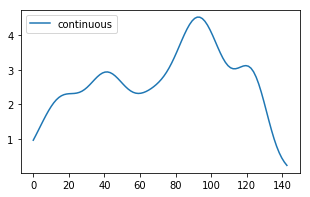

In [393]:
plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
# axs.plot(x,intensity,label='intensity')
# axs.plot(training[0],np.zeros(len(training[0])),linestyle='None', marker='|', color='g', markersize=10)
# axs.scatter(training[0],intensity_pre,label='dots',s=3)
axs.plot(xx,intensity_ave,label='continuous')
plt.legend()
plt.show()

In [396]:
intensity_ave

array([0.96277155, 1.10497925, 1.25163933, 1.40002668, 1.54691506,
       1.68871544, 1.82169387, 1.9422589 , 2.04729515, 2.13450733,
       2.20273086, 2.2521617 , 2.28446252, 2.30271358, 2.31119473,
       2.3150072 , 2.31956762, 2.33002734, 2.35068553, 2.38446994,
       2.43255524, 2.49417333, 2.56664683, 2.64564783, 2.72565441,
       2.80055105, 2.86430002, 2.91160251, 2.93847058, 2.94264445,
       2.92381076, 2.88360404, 2.8254005 , 2.75393777, 2.67481268,
       2.59392023, 2.5168997 , 2.44864879, 2.39295568, 2.35228296,
       2.32771898, 2.31909325, 2.325234  , 2.34433042, 2.37434992,
       2.41345394, 2.46035477, 2.51456227, 2.57648208, 2.647346  ,
       2.72897865, 2.82342812, 2.93251063, 3.05733387, 3.19786997,
       3.35264378, 3.51858632, 3.69107934, 3.86418853, 4.03105613,
       4.18440243, 4.31707452, 4.42258096, 4.49556153, 4.5321588 ,
       4.53027799, 4.48973796, 4.41232536, 4.30176409, 4.16360406,
       4.00502145, 3.83451138, 3.66145056, 3.49551487, 3.34595

In [395]:
sum(intensity_ave*1.44)

384.6499581824124

## 1 training sequence

In [263]:
logL_test=[]
for i in range(5):
    logL_test.append(loglikelihood(np.array(intensity_ave),training[i],T))

In [264]:
np.average(logL_test)

-86.45658281540842

## 5 training sequence

In [269]:
logL_test=[]
for i in range(5):
    logL_test.append(loglikelihood(np.array(intensity_ave),training[i],T))

In [270]:
np.average(logL_test)

-10.154211656446353

## 10 training sequence

In [275]:
logL_test=[]
for i in range(5):
    logL_test.append(loglikelihood(np.array(intensity_ave),training[i],T))

In [276]:
np.average(logL_test)

2.600095473004319

## 15 training sequence

In [281]:
logL_test=[]
for i in range(5):
    logL_test.append(loglikelihood(np.array(intensity_ave),training[i],T))

In [282]:
np.average(logL_test)

7.20940406710198

## 20 training sequence

In [293]:
logL_test=[]
for i in range(5):
    logL_test.append(loglikelihood(np.array(intensity_ave),training[i],T))

In [294]:
np.average(logL_test)

6.13697218536056

In [369]:
def time_rescaling_homopoisson(points_poisson,lamda):
    N=len(points_poisson)
    points_rescale=[]
    for i in range(N):
        time_rescale=lamda*points_poisson[i]
        points_rescale.append(time_rescale)
    return points_rescale

In [385]:
def time_rescaling_inhomopoisson(points_poisson, lamda, T):
    N=len(points_poisson)
    delta_t=T/len(lamda)
    points_rescale=[]
    for i in range(N):
        time_rescale=0
        time_rescale+=sum(lamda[:int(points_poisson[i]/delta_t)]*delta_t)
        time_rescale+=lamda[int(points_poisson[i]/delta_t)]*delta_t*(points_poisson[i]/delta_t-int(points_poisson[i]/delta_t))
        points_rescale.append(time_rescale)
    return points_rescale

In [373]:
points_rescale_rkhs=time_rescaling_poisson(np.sort(training[1]),np.array(intensity_ave),T)

In [374]:
points_rescale_homo=time_rescaling_homopoisson(np.sort(training[1]),len(training[1])/T)

In [375]:
points_rescale_rkhs=1-np.exp(-np.array(points_rescale_rkhs)+np.array([points_rescale_rkhs[0]]+points_rescale_rkhs[:-1]))

In [376]:
points_rescale_homo=1-np.exp(-np.array(points_rescale_homo)+np.array([points_rescale_homo[0]]+points_rescale_homo[:-1]))

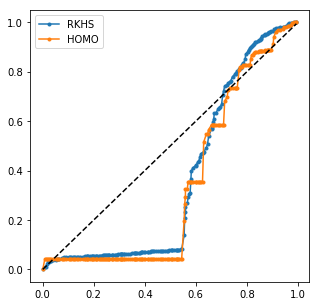

In [383]:
plt.figure(1,figsize=(5,5))
a = np.random.uniform(0,1,len(points_rescale_rkhs))
percs = np.linspace(0,100,201)
qn_a = np.percentile(a, percs)
qn_rkhs = np.percentile(points_rescale_rkhs, percs)
qn_homo = np.percentile(points_rescale_homo, percs)

plt.plot(qn_a,qn_rkhs, ls='-', marker="o",markersize=3,label='RKHS')
plt.plot(qn_a,qn_homo, ls='-', marker="o",markersize=3,label='HOMO')

x = np.linspace(qn_a.min(),qn_a.max())
plt.plot(x,x, color="k", ls="--")
plt.legend()

plt.show()

In [121]:
k_s,eigenv_s_1,eigenv=k_sim(1,5,10,0.01,1,1)

In [122]:
k_s,eigenv_s_2,eigenv=k_sim(1,5,10,0.01,1,0.2)

In [125]:
k_s,eigenv_s_3,eigenv=k_sim(1,5,10,0.01,1,5)

In [127]:
k_s,eigenv_s_4,eigenv=k_sim(1,5,10,0.01,1,0.1)

In [123]:
len(eigenv),len(eigenv_s)

(10, 10)

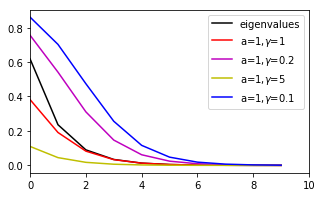

In [129]:
plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
axs.plot(range(len(eigenv)),eigenv,'k-',label='eigenvalues')
axs.plot(range(len(eigenv_s_1)),eigenv_s_1,'r-',label='a=1,$\gamma$=1')
axs.plot(range(len(eigenv_s_2)),eigenv_s_2,'m-',label='a=1,$\gamma$=0.2')
axs.plot(range(len(eigenv_s_3)),eigenv_s_3,'y-',label='a=1,$\gamma$=5')
axs.plot(range(len(eigenv_s_4)),eigenv_s_4,'b-',label='a=1,$\gamma$=0.1')
plt.xlim(0,len(eigenv))
plt.legend()
plt.show()

In [150]:
k_s_0_0=[expo_quad_kernel(1,0.01,0,xx) for xx in np.linspace(0,50,100)] ## k(0,(0,4))

In [151]:
k_s_0_1=[k_sim(0,xx,50,0.01,1,1) for xx in np.linspace(0,50,100)] ## gamma=1

In [152]:
k_s_0_2=[k_sim(0,xx,50,0.01,1,0.2) for xx in np.linspace(0,50,100)] ## gamma=0.2

In [153]:
k_s_0_3=[k_sim(0,xx,50,0.01,1,5) for xx in np.linspace(0,50,100)] ## gamma=5

In [154]:
k_s_0_4=[k_sim(0,xx,50,0.01,1,0.1) for xx in np.linspace(0,50,100)] ## gamma=0.1

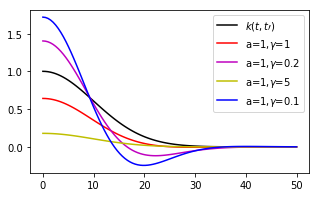

In [155]:
plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
axs.plot(np.linspace(0,50,100),k_s_0_0,'k-',label='$k(t,t\prime)$')
axs.plot(np.linspace(0,50,100),k_s_0_1,'r-',label='a=1,$\gamma$=1')
axs.plot(np.linspace(0,50,100),k_s_0_2,'m-',label='a=1,$\gamma$=0.2')
axs.plot(np.linspace(0,50,100),k_s_0_3,'y-',label='a=1,$\gamma$=5')
axs.plot(np.linspace(0,50,100),k_s_0_4,'b-',label='a=1,$\gamma$=0.1')
plt.legend()
plt.show()